In [32]:
# import Libraries
import numpy as np
import cv2
import joblib
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [33]:
# === LOAD MNIST ===
def load_mnist_data(max_samples=3000):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.to_numpy().astype(np.float32).reshape(-1, 28, 28)
    y = mnist.target.astype(int)
    return X[:max_samples], y[:max_samples]

In [34]:
# === EXTRACT PATCHES ===
def extract_random_patches(images, patch_size=7, stride=1, max_patches=50000):
    patches = []
    for img in images:
        for i in range(0, img.shape[0] - patch_size + 1, stride):
            for j in range(0, img.shape[1] - patch_size + 1, stride):
                patch = img[i:i+patch_size, j:j+patch_size]
                patch = patch - np.mean(patch)
                patches.append(patch.flatten())
                if len(patches) >= max_patches:
                    return np.array(patches)
    return np.array(patches)

In [35]:
# === LEARN PCA FILTERS ===
def learn_pca_filters(patches, num_filters, patch_size):
    pca = PCA(n_components=num_filters)
    pca.fit(patches)
    filters = pca.components_.reshape((num_filters, patch_size, patch_size))
    return filters, pca

In [36]:
# === CONVOLVE ===
def convolve_images(images, filters):
    fmap_all = []
    for img in images:
        maps = [cv2.filter2D(img, -1, f) for f in filters]
        fmap_all.append(np.stack(maps))
    return np.array(fmap_all)

In [37]:
# === BINARY HASHING + HISTOGRAM ===
def binary_hashing(feature_maps):
    # feature_maps: shape (n_samples, n_filters, H, W)
    all_hashed = []
    for fmap in feature_maps:
        bin_stack = (fmap > 0).astype(np.uint8)  # (n_filters, H, W)
        powers = 2 ** np.arange(bin_stack.shape[0])[::-1].reshape((-1, 1, 1))
        hashed = np.sum(bin_stack * powers, axis=0)  # (H, W)
        all_hashed.append(hashed)
    return np.array(all_hashed)  # shape (n_samples, H, W)

In [38]:
# === BLOCK HISTOGRAM ===
def block_histogram(images, block_size=(7, 7), num_bins=256, overlap=0.5):
    n, h, w = images.shape
    bh, bw = block_size
    step_h = int(bh * (1 - overlap))
    step_w = int(bw * (1 - overlap))
    features = []
    for img in images:
        blocks = []
        for i in range(0, h - bh + 1, step_h):
            for j in range(0, w - bw + 1, step_w):
                block = img[i:i + bh, j:j + bw]
                hist, _ = np.histogram(block, bins=num_bins, range=(0, num_bins))
                blocks.extend(hist)
        features.append(np.array(blocks))
    return np.stack(features)

In [39]:
# === TRAIN + SAVE MODEL ===
def train_and_save_model():
    print("📥 Loading data...")
    X, y = load_mnist_data(3000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

    print("🧩 Stage 1 PCA...")
    patches1 = extract_random_patches(X_train, patch_size=7, stride=1, max_patches=50000)
    filters1, pca1 = learn_pca_filters(patches1, num_filters=6, patch_size=7)

    print("🎛 Convolution stage 1...")
    fmap1_train = convolve_images(X_train, filters1)
    fmap1_test = convolve_images(X_test, filters1)

    print("🧩 Stage 2 PCA...")
    combined_maps = np.array([np.sum(fm, axis=0) for fm in fmap1_train])
    patches2 = extract_random_patches(combined_maps, patch_size=7, stride=1, max_patches=50000)
    filters2, pca2 = learn_pca_filters(patches2, num_filters=11, patch_size=7)

    print("🎛 Convolution stage 2...")
    fmap2_train = np.array([np.stack([cv2.filter2D(np.sum(fm, axis=0), -1, f) for f in filters2]) for fm in fmap1_train])
    fmap2_test = np.array([np.stack([cv2.filter2D(np.sum(fm, axis=0), -1, f) for f in filters2]) for fm in fmap1_test])

    print("🔐 Feature encoding...")
    hashed_train = binary_hashing(fmap2_train)
    hashed_test = binary_hashing(fmap2_test)
    features_train = block_histogram(hashed_train, block_size=(7, 7), overlap=0.5)
    features_test = block_histogram(hashed_test, block_size=(7, 7), overlap=0.5)

    print("🎯 Training classifier...")
    clf = LinearSVC(max_iter=3000)
    clf.fit(features_train, y_train)

    acc = clf.score(features_test, y_test)
    print(f"✅ Accuracy: {acc * 100:.2f}%")

    print("💾 Saving model...")
    joblib.dump({'filters1': filters1, 'filters2': filters2, 'clf': clf}, "pcn_model.joblib")
    print("✅ Model saved as pcn_model.joblib")

train_and_save_model()

📥 Loading data...
🧩 Stage 1 PCA...
🎛 Convolution stage 1...
🧩 Stage 2 PCA...
🎛 Convolution stage 2...
🔐 Feature encoding...
🎯 Training classifier...
✅ Accuracy: 95.50%
💾 Saving model...
✅ Model saved as pcn_model.joblib


🔢 Nomor plat terdeteksi: 3300


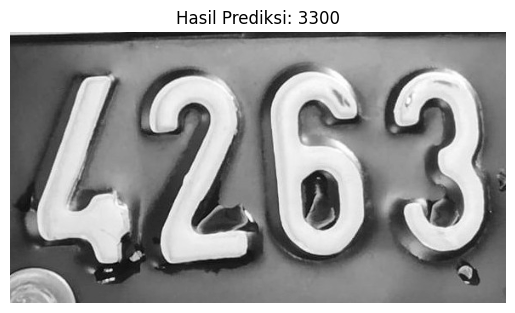

'3300'

In [41]:
# Fungsi deteksi otomatis untuk gambar plat nomor berisi 4 angka
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Muat model PCA + SVM dari file
def load_model(model_path="pcn_model.joblib"):
    model = joblib.load(model_path)
    return model['filters1'], model['filters2'], model['clf']

# Ekstraksi angka dari gambar plat
def preprocess_plate_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Gambar tidak ditemukan.")

    img = 255 - img
    h, w = img.shape

    digit_width = w // 4
    digits = []

    for i in range(4):
        digit = img[:, i*digit_width:(i+1)*digit_width]
        digit = cv2.resize(digit, (20, 20))
        digit = cv2.copyMakeBorder(digit, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
        digit = digit.astype(np.float32) / 255.0
        digits.append(digit)
    return digits

# Binary hashing fungsi
def binary_hashing(feature_maps):
    all_hashed = []
    for fmap in feature_maps:
        bin_stack = (fmap > 0).astype(np.uint8)
        powers = 2 ** np.arange(bin_stack.shape[0])[::-1].reshape((-1, 1, 1))
        hashed = np.sum(bin_stack * powers, axis=0)
        all_hashed.append(hashed)
    return np.array(all_hashed)

# Histogram blok dari gambar
def block_histogram(images, block_size=(7, 7), num_bins=256, overlap=0.5):
    n, h, w = images.shape
    bh, bw = block_size
    step_h = int(bh * (1 - overlap))
    step_w = int(bw * (1 - overlap))
    features = []
    for img in images:
        blocks = []
        for i in range(0, h - bh + 1, step_h):
            for j in range(0, w - bw + 1, step_w):
                block = img[i:i + bh, j:j + bw]
                hist, _ = np.histogram(block, bins=num_bins, range=(0, num_bins))
                blocks.extend(hist)
        features.append(np.array(blocks))
    return np.stack(features)

# Fungsi utama prediksi 4 digit angka dari plat
def predict_4_digit_plate(image_path, model_path="pcn_model.joblib", show=True):
    filters1, filters2, clf = load_model(model_path)
    digits = preprocess_plate_image(image_path)
    predictions = []

    for digit in digits:
        fmap1 = np.stack([cv2.filter2D(digit, -1, f) for f in filters1])
        combined = np.sum(fmap1, axis=0)
        fmap2 = np.stack([cv2.filter2D(combined, -1, f) for f in filters2])
        fmap2 = np.expand_dims(fmap2, axis=0)

        hashed = binary_hashing(fmap2)
        feature = block_histogram(hashed)[0]

        pred = clf.predict([feature])[0]
        predictions.append(str(pred))

    plate_number = "".join(predictions)

    print(f"🔢 Nomor plat terdeteksi: {plate_number}")

    if show:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray')
        plt.title(f"Hasil Prediksi: {plate_number}")
        plt.axis('off')
        plt.show()

    return plate_number

predict_4_digit_plate("plat1.jpg")